### Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib
import warnings
warnings.filterwarnings("ignore")


### Load the Data

In [3]:
df = pd.read_csv(r"C:/Users/Asus/Desktop/IMDb Movies India.csv", encoding='latin1')
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


#### Drop Missing & Zero Ratings

In [5]:
# Clean Rating column
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df.dropna(subset=['Rating'])
df = df[(df['Rating'] >= 1) & (df['Rating'] <= 10)]


#### Missing Value Analysis

In [6]:
df.isnull().sum()

Name           0
Year           0
Duration    2068
Genre        102
Rating         0
Votes          0
Director       5
Actor 1      125
Actor 2      200
Actor 3      292
dtype: int64

In [7]:
(df.isnull().sum() / len(df)) * 100


Name         0.000000
Year         0.000000
Duration    26.114408
Genre        1.288041
Rating       0.000000
Votes        0.000000
Director     0.063139
Actor 1      1.578482
Actor 2      2.525571
Actor 3      3.687334
dtype: float64

#### Data Cleaning & Type Conversion

In [8]:
#Fix Year Column (Extract Digits)
df['Year'] = df['Year'].astype(str).str.extract('(\d{4})')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')


In [9]:
#Fix Duration Column
df['Duration'] = df['Duration'].astype(str).str.replace(' min','')
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')


In [10]:
#Convert Votes to Numeric
df['Votes'] = df['Votes'].astype(str).str.replace(',', '')
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')


#### Handling Missing Values

In [11]:
#Fill Numerical Missing Values (Median)
num_cols = ['Year', 'Duration', 'Votes']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)


In [12]:
#Fill Categorical Missing Values
cat_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
for col in cat_cols:
    df[col].fillna("Unknown", inplace=True)


In [13]:
df.isnull().sum()


Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

### EDA

#### Rating Distribution (Imbalance Check)

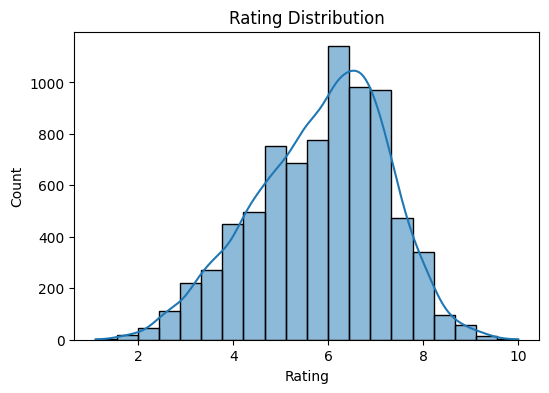

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title("Rating Distribution")
plt.show()

This shows how ratings are distributed and helps to understand imbalance in regression.

#### Votes Distribution & Log Transformation

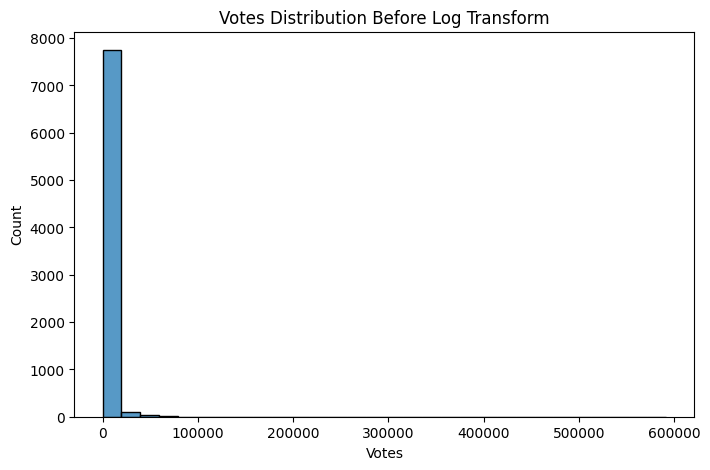

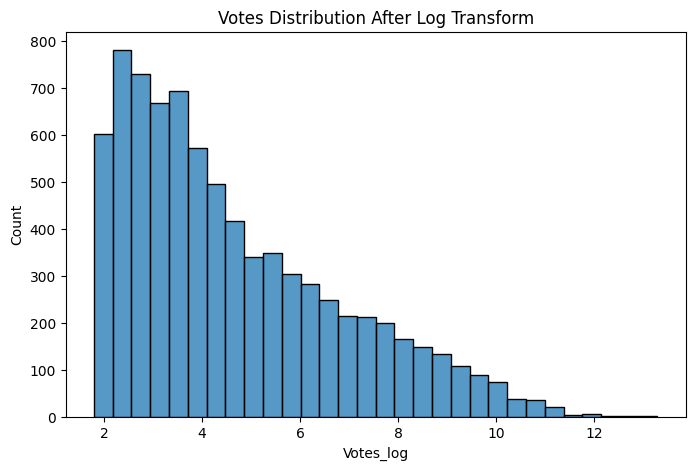

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df['Votes'], bins=30)
plt.title("Votes Distribution Before Log Transform")
plt.show()

df['Votes_log'] = np.log1p(df['Votes'])

plt.figure(figsize=(8,5))
sns.histplot(df['Votes_log'], bins=30)
plt.title("Votes Distribution After Log Transform")
plt.show()

Votes are heavily skewed with extreme outliers, so the use of log transformation before model training is required.

#### Top Movie Genres

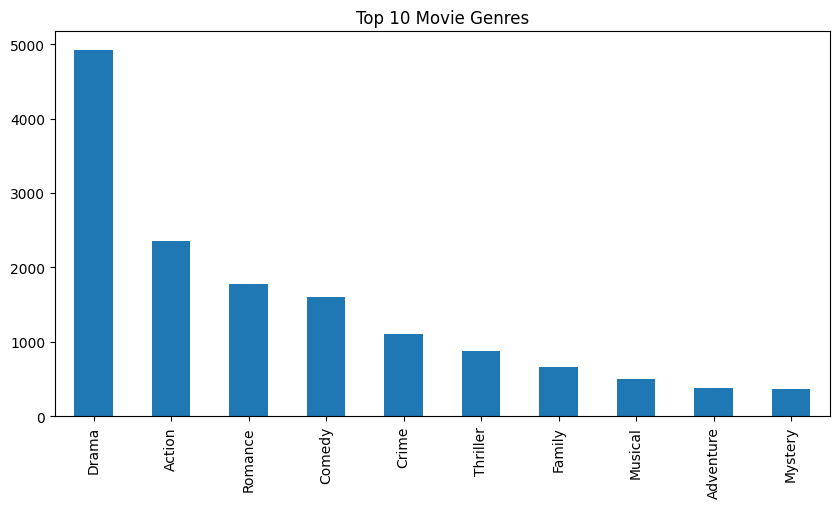

In [16]:
genre_df = df['Genre'].str.split(', ', expand=True).stack()

plt.figure(figsize=(10,5))
genre_df.value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Movie Genres")
plt.show()


#### Rating vs Numerical Features

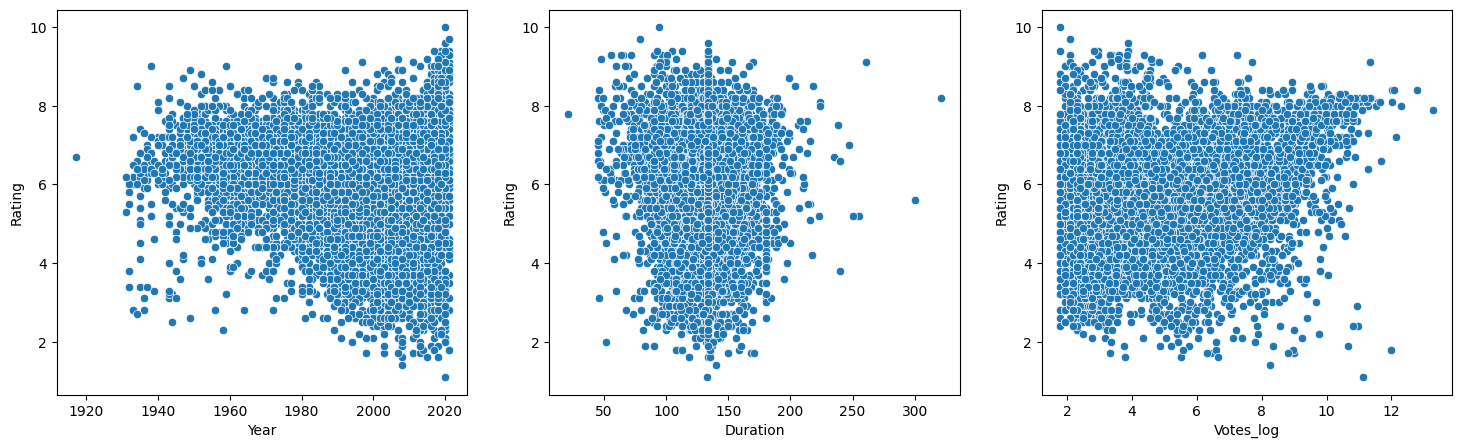

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.scatterplot(x='Year', y='Rating', data=df, ax=axes[0])
sns.scatterplot(x='Duration', y='Rating', data=df, ax=axes[1])
sns.scatterplot(x='Votes_log', y='Rating', data=df, ax=axes[2])

plt.show()


Movie ratings show a slight upward trend over the years, indicating that more recent movies tend to receive marginally higher ratings, though variability remains high.

Movie duration does not exhibit a strong linear relationship with ratings, suggesting that longer movies are not necessarily rated higher.

Ratings tend to increase moderately with higher log-transformed vote counts, indicating that more widely rated movies generally receive better ratings.

#### Feature Selection

In [18]:
features = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3',
            'Year', 'Duration', 'Votes']

target = 'Rating'

X = df[features]
y = df[target]


#### Preprocessing Pipeline

In [19]:
#Preprocessing Pipeline
cat_features = ['Genre', 'Director', 'Actor 1']
num_features = ['Year', 'Duration']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])


#### Train-Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model building, training & Evaluation

In [21]:
#Linear Regression
lr_model = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

lr_model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Genre', 'Director',
                                                   'Actor 1'])])),
                ('model', LinearRegression())])

In [22]:
#Random Forest Regressor
rf_model = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Genre', 'Director',
                                                   'Actor 1'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [23]:
#Gradient Boosting Regressor
gb_model = Pipeline([
    ('prep', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

gb_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Genre', 'Director',
                                                   'Actor 1'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [24]:
def evaluate(model, name):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"----- {name} -----")
    print("MAE :", mae)
    print("MSE :", mse)
    print("RMSE:", rmse)
    print("R2  :", r2)
    print()
    
    return r2


In [25]:
r2_lr = evaluate(lr_model, "Linear Regression")
r2_rf = evaluate(rf_model, "Random Forest")
r2_gb = evaluate(gb_model, "Gradient Boosting")


----- Linear Regression -----
MAE : 1.1209270200224517
MSE : 2.1744169217182896
RMSE: 1.4745904250734472
R2  : -0.16957889633446954

----- Random Forest -----
MAE : 0.9040744949494948
MSE : 1.3955590842803027
RMSE: 1.1813378366412814
R2  : 0.249354418989587

----- Gradient Boosting -----
MAE : 0.9427813994537841
MSE : 1.4435694600311726
RMSE: 1.20148635449229
R2  : 0.22353052030555143



#### Best Model Selection

In [26]:
models = {
    "Linear": lr_model,
    "RandomForest": rf_model,
    "GradientBoost": gb_model
}

best_model_name = max(zip([r2_lr, r2_rf, r2_gb], models.keys()))[1]
best_model = models[best_model_name]

print("Best Model:", best_model_name)


Best Model: RandomForest


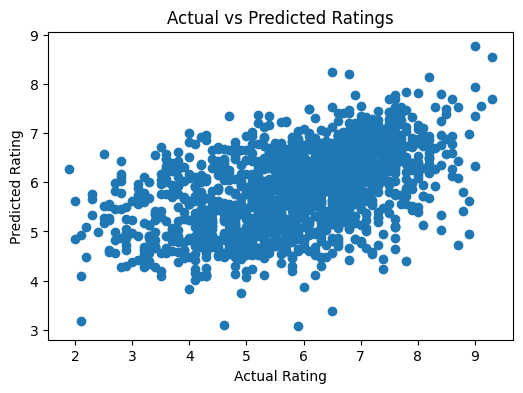

In [27]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted Ratings")
plt.show()


In [28]:
joblib.dump(best_model, "movie_rating_model.pkl")
print("Model Saved Successfully")

Model Saved Successfully


In [29]:
loaded_model = joblib.load("movie_rating_model.pkl")

new_movie = pd.DataFrame({
    'Genre': ['Action, Drama, Mystery'],
    'Director': ['P'],
    'Actor 1': ['M'],
    'Year': [2004],
    'Duration': [120]
})

predicted_rating = loaded_model.predict(new_movie)
print("Predicted Rating:", predicted_rating[0])


Predicted Rating: 4.8070000000000075
